In [5]:

# load model
# create dataloader
# load metadata
# forward and compute fw/bw consistency


In [6]:
import sys
from dotmap import DotMap

sys.path.append('../../')

from utils.io import load_yaml

server = 'local'
server = DotMap(load_yaml('../../config/servers.yml')[server])

In [7]:
import pandas as pd

meta_df_name = '../21_06_21_cholec80_dissection/cholec80_splits_transforms.pkl'
meta_df = pd.read_pickle(meta_df_name)
meta_df.aug_transforms = None  # no transforms for evaluation
meta_df.pre_transforms = meta_df.pre_transforms.transform(lambda x:
    [
        x[0], x[1],
        {
            'module': 'kornia.color',
            'type': 'RgbToBgr',
            'kwargs': {}
        }
    ]
)


# meta_df.pre_transforms.iloc[0].append(
#     {
#         'module': 'kornia.color',
#         'type': 'RgbToBgr',
#         'kwargs': {}
#     }
# )
# meta_df
meta_df.train = False
meta_df_sample = meta_df.sample(frac=0.1, random_state=42)
meta_df_sample.train = True
meta_df.update(meta_df_sample)
meta_df.to_pickle('cholec80_splits_transforms.pkl')

In [8]:
import os
import pandas as pd
from dotmap import DotMap

from utils.io import load_yaml
from utils.io import load_pickle, save_pickle
from lightning_data_modules import VideoDataModule


# meta_df_name = '../21_06_21_cholec80_dissection/cholec80_splits_transforms.pkl'
# meta_df = pd.read_pickle(meta_df_name)
# meta_df.aug_transforms = None  # no transforms for evaluation

# shuffle meta df
meta_df = meta_df.sample(frac=0.1, random_state=1)

test_md_name = 'cholec80_fraction_shuffle_splits_test_md.pkl' # -> 'cholec80_fraction_shuffle_splits_test_md_full.pkl'
test_md = None
print('\nLooking for {}'.format(test_md_name))
if os.path.exists(test_md_name):
    test_md = load_pickle(test_md_name)
    print('Found.')
else:
    print('Could not find {}. Generating metadata.'.format(test_md_name))

# load cholec80 splits
prefix = server.database.location
clip_length_in_frames = 5
frames_between_clips = clip_length_in_frames
frame_rate = 5
train_split = 0.8
batch_size = 1
num_workers = 4
random_state = 42

dm = VideoDataModule(
    meta_df,
    prefix=prefix,
    clip_length_in_frames=clip_length_in_frames,
    frames_between_clips=frames_between_clips,
    frame_rate=frame_rate,
    train_split=train_split,
    batch_size=batch_size,
    num_workers=num_workers,
    random_state=random_state,
    test_metadata=test_md
)

_, _, test_md = dm.setup('test')

# store metadata
save_pickle(test_md_name, test_md)



Looking for cholec80_fraction_shuffle_splits_test_md.pkl
Found.


In [5]:
import cv2
import os
from tqdm import tqdm
from kornia import tensor_to_image, warp_perspective
import torch
import numpy as np

from utils.processing import frame_pairs, forward_backward_sequence, four_point_homography_to_matrix, image_edges
from utils.viz import yt_alpha_blend
from utils.io import generate_path, load_yaml
from lightning_modules import DeepImageHomographyEstimationModuleBackbone

visualize = False
visualize_end2end = False

rho = 64
rho_32_models = [
    # VGG
    'vgg',

    # ResNet
    'resnet/18',
    'resnet/34',
    'resnet/50',

    # EfficientNet
    'efficient_net/b0',
    'efficient_net/b1',
    'efficient_net/b2',
    'efficient_net/b3',
    'efficient_net/b4',
    'efficient_net/b5',

    # RegNetY
    'regnet_y/400_mf',
    'regnet_y/600_mf',
    'regnet_y/800_mf',
    'regnet_y/1_6_gf',
    'regnet_y/4_0_gf',
    'regnet_y/6_4_gf'
]

rho_64_models = [
    # VGG
    'vgg/64',

    # ResNet
    'resnet/64/18',
    'resnet/64/34',
    'resnet/64/50',

    # EfficientNet
    'efficient_net/64/b0',
    'efficient_net/64/b1',
    'efficient_net/64/b2',
    'efficient_net/64/b3',
    'efficient_net/64/b4',
    'efficient_net/64/b5',

    # RegNetY
    'regnet_y/64/400_mf',
    'regnet_y/64/600_mf',
    'regnet_y/64/800_mf',
    'regnet_y/64/1_6_gf',
    'regnet_y/64/4_0_gf',
    'regnet_y/64/6_4_gf'
]


test_dl = dm.test_dataloader()

for model_path in rho_64_models:
    print('Testing {}'.format(model_path))
    prefix = '/home/martin/Tresors/homography_imitation_learning_logs/ae_cai'

    configs = load_yaml(os.path.join(prefix, model_path, 'version_0', 'config.yml'))
    model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(prefix, model_path, 'version_0', 'checkpoints/epoch=49-step=94349.ckpt'), shape=configs['model']['shape'])

    device = 'cpu'
    if torch.cuda.is_available():
        print('Running with CUDA backend.')
        device = 'cuda'

    model.to(device)
    model = model.eval()
    model.freeze()


    log_df = pd.DataFrame(columns=['duv'])

    for batch in tqdm(test_dl):

        vid, aug_vid, frame_rate, video_fps, video_idx, idx = batch

        forward, backward = forward_backward_sequence(vid)

        fw_i, fw_ip1 = frame_pairs(forward)
        bw_i, bw_ip1 = frame_pairs(backward)

        fw_i, fw_ip1 = fw_i.squeeze(), fw_ip1.squeeze()
        bw_i, bw_ip1 = bw_i.squeeze(), bw_ip1.squeeze()

        imgs, wrps = torch.cat((fw_i, bw_i), axis=0), torch.cat((fw_ip1, bw_ip1), axis=0)

        imgs, wrps = dm.transfer_batch_to_device(imgs, device), dm.transfer_batch_to_device(wrps, device)

        duvs = model(imgs, wrps)

        log_df = log_df.append({
            'duv': duvs.sum(0).cpu().numpy()
        }, ignore_index=True)

        # print(torch.linalg.norm(duvs.sum(axis=0), dim=1))

        if visualize:
            if visualize_end2end:
                img = imgs[0]
                H = four_point_homography_to_matrix(image_edges(img.unsqueeze(0)), duvs.sum(0))
                img_pred = warp_perspective(img.unsqueeze(0), H, imgs.shape[-2:])

                img, img_pred = tensor_to_image(img.cpu()), tensor_to_image(img_pred.cpu())
                blend = yt_alpha_blend(img, img_pred)
                cv2.imshow('blend', blend)
                cv2.waitKey()
            else:
                Hs = four_point_homography_to_matrix(image_edges(imgs), duvs)
                wrps_pred = warp_perspective(imgs, torch.inverse(Hs), wrps.shape[-2:])

                for idx, (img, wrp, wrp_pred) in enumerate(zip(imgs, wrps, wrps_pred)):
                    img, wrp, wrp_pred = tensor_to_image(img.cpu()), tensor_to_image(wrp.cpu()), tensor_to_image(wrp_pred.cpu())
                    blend = yt_alpha_blend(wrp, wrp_pred)
                    cv2.imshow('blend', blend)
                    cv2.imshow('img', img)
                    cv2.waitKey()

    category = model_path.split('/')[-0]
    export = model_path.split('/')[-1]
    output_path = 'fw_bw_consistency/rho_{}/{}'.format(rho, category)
    generate_path(output_path)

    log_df.to_pickle('{}/{}_duv.pkl'.format(output_path, export))

if visualize:
    cv2.destroyAllWindows()


Testing regnet_y/64/6_4_gf
Running with CUDA backend.


  0%|          | 0/960 [00:00<?, ?it/s]/home/martin/miniconda3/envs/hil/lib/python3.7/site-packages/torchvision/io/video.py:116: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "


In [9]:
import cv2
import numpy as np
from tqdm import tqdm
from kornia import tensor_to_image, warp_perspective
import torch

from utils.processing import FeatureHomographyEstimation
from utils.processing import frame_pairs, forward_backward_sequence, four_point_homography_to_matrix, image_edges
from utils.viz import yt_alpha_blend

visualize = False
visualize_end2end = False

test_dl = dm.test_dataloader()

log_df = pd.DataFrame(columns=['duv'])

fd = cv2.xfeatures2d.SURF_create()
fh = FeatureHomographyEstimation(fd)

for batch in tqdm(test_dl):
    vid, aug_vid, frame_rate, video_fps, video_idx, idx = batch

    forward, backward = forward_backward_sequence(vid)

    fw_i, fw_ip1 = frame_pairs(forward)
    bw_i, bw_ip1 = frame_pairs(backward)

    fw_i, fw_ip1 = fw_i.squeeze(), fw_ip1.squeeze()
    bw_i, bw_ip1 = bw_i.squeeze(), bw_ip1.squeeze()

    imgs, wrps = torch.cat((fw_i, bw_i), axis=0), torch.cat((fw_ip1, bw_ip1), axis=0)

    duvs = []

    for img, wrp in zip(imgs, wrps):
        img, wrp = tensor_to_image(img), tensor_to_image(wrp)
        H, duv = fh((img*255).astype(np.uint8), (wrp*255).astype(np.uint8))

        if H is not None:
            duvs.append(duv)

    if duv is not None:
        duvs = np.array(duvs)

        log_df = log_df.append({
            'duv': duvs.sum(0)
        }, ignore_index=True)

    if visualize_end2end:
        img = imgs[0]
        H = four_point_homography_to_matrix(image_edges(img.unsqueeze(0)), duvs.sum(0))
        img_pred = warp_perspective(img.unsqueeze(0), H, imgs.shape[-2:])

        img, img_pred = tensor_to_image(img.cpu()), tensor_to_image(img_pred.cpu())
        blend = yt_alpha_blend(img, img_pred)
        cv2.imshow('blend', blend)
        cv2.waitKey()

    
log_df.to_pickle('ft.pkl')
        



  0%|          | 0/960 [00:00<?, ?it/s]/home/martin/miniconda3/envs/hil/lib/python3.7/site-packages/torchvision/io/video.py:116: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "
/home/martin/miniconda3/envs/hil/lib/python3.7/site-packages/torchvision/io/video.py:116: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "
/home/martin/miniconda3/envs/hil/lib/python3.7/site-packages/torchvision/io/video.py:116: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "
/home/martin/miniconda3/envs/hil/lib/python3.7/site-packages/torchvision/io/video.py:116: UserWarning: The pts_unit

ft/SURF/32 - 2.71/5.26/10.72/41.32
vgg/vgg/32 - 13.84/17.13/20.71/26.77
resnet/18/32 - 2.68/3.34/4.61/9.28
resnet/34/32 - 2.60/3.38/4.51/10.06
resnet/50/32 - 2.89/3.45/4.53/11.00
efficient_net/b0/32 - 2.68/3.29/4.41/9.38
efficient_net/b1/32 - 2.42/3.14/4.49/11.40
efficient_net/b2/32 - 2.51/3.20/4.32/10.68
efficient_net/b3/32 - 2.96/3.78/5.09/10.18
efficient_net/b4/32 - 2.87/3.53/4.92/12.86
efficient_net/b5/32 - 2.93/3.65/4.61/10.76
regnet_y/400_mf/32 - 2.69/3.52/4.94/11.29
regnet_y/600_mf/32 - 3.30/4.50/6.29/14.28
regnet_y/800_mf/32 - 3.23/4.24/5.69/13.15
regnet_y/1_6_gf/32 - 3.35/4.30/5.78/11.58
regnet_y/4_0_gf/32 - 2.86/3.71/5.14/11.67
regnet_y/6_4_gf/32 - 2.78/3.51/5.08/17.80
ft/SURF/64 - 2.71/5.26/10.72/41.32
vgg/vgg/64 - 79.69/90.30/102.54/122.00
resnet/18/64 - 6.06/7.15/10.02/21.85
resnet/34/64 - 4.21/5.25/7.12/17.63
resnet/50/64 - 4.85/5.64/7.15/16.20
efficient_net/b0/64 - 11.29/14.67/20.63/39.48
efficient_net/b1/64 - 8.28/11.25/16.43/32.69
efficient_net/b2/64 - 13.73/19.68/29.1

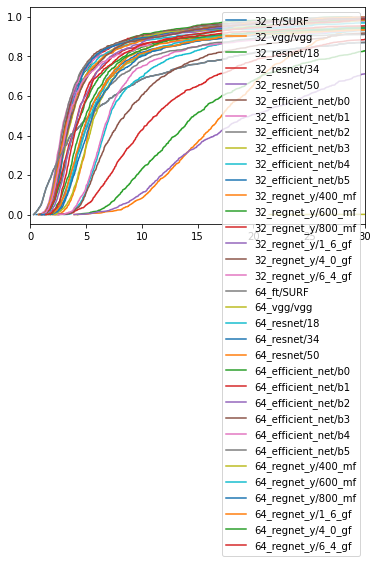

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


rhos = [32, 64]
# fds = ['64_34', '64_6_4_gf', '64_b4', '400_mf', 'b4', '1_6_gf', 'ft']
fds = [
    'ft/SURF',
    'vgg/vgg',
    'resnet/18','resnet/34','resnet/50',
    # 'resnet/34',
    'efficient_net/b0','efficient_net/b1','efficient_net/b2','efficient_net/b3','efficient_net/b4','efficient_net/b5',
    'regnet_y/400_mf','regnet_y/600_mf','regnet_y/800_mf','regnet_y/1_6_gf','regnet_y/4_0_gf','regnet_y/6_4_gf'
    # 'resnet/18','resnet/34',
    # 'efficient_net/b2', 'efficient_net/b5',
    # 'regnet_y/400_mf', 'regnet_y/4_0_gf'
]

parameters = {
    'ft/SURF': 0,
    'vgg/vgg': 132868840,
    'resnet/18': 11689512, 'resnet/34': 21797672, 'resnet/50': 25557032,
    'efficient_net/b0': 5288548, 'efficient_net/b1': 7794184,'efficient_net/b2': 9109994,'efficient_net/b3': 12233232, 'efficient_net/b4': 19341616,'efficient_net/b5': 30389784,
    'regnet_y/400_mf': 4344144, 'regnet_y/600_mf': 6055160, 'regnet_y/800_mf': 6263168, 'regnet_y/1_6_gf': 11202430, 'regnet_y/4_0_gf': 20646656, 'regnet_y/6_4_gf': 30583252

}

stats_dfs = []
eval_dfs = []

for rho in rhos:

    eval_df = pd.DataFrame(columns=['parameters', 'th30', 'th50', 'th70', 'th90'])

    for fd in fds:
        data_path = 'fw_bw_consistency/rho_{}/{}_duv.pkl'.format(rho, fd)
        duv_df = pd.read_pickle(data_path)

        duv_df['duv_mpd'] = duv_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

        stats_df = duv_df.groupby('duv_mpd')['duv_mpd'].agg('count').pipe(pd.DataFrame).rename(columns = {'duv_mpd': 'frequency'})

        # PDF
        stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

        # CDF
        stats_df['cdf'] = stats_df['pdf'].cumsum()
        stats_df = stats_df.reset_index()
        stats_dfs.append(stats_df)
    
        th30 = stats_df[stats_df.cdf < 0.3].iloc[-1]
        th50 = stats_df[stats_df.cdf < 0.5].iloc[-1]
        th70 = stats_df[stats_df.cdf < 0.7].iloc[-1]
        th90 = stats_df[stats_df.cdf < 0.9].iloc[-1]
        eval_df = eval_df.append({
            'parameters': parameters[fd],
            'th30': th30.duv_mpd,
            'th50': th50.duv_mpd,
            'th70': th70.duv_mpd,
            'th90': th90.duv_mpd
        }, ignore_index=True)
        print('{}/{} - {:.2f}/{:.2f}/{:.2f}/{:.2f}'.format(fd, rho, th30.duv_mpd, th50.duv_mpd, th70.duv_mpd, th90.duv_mpd))

    # for stats_df, fd in zip(stats_dfs, fds):

        plt.plot(stats_df['duv_mpd'], stats_df['cdf'], label='{}_{}'.format(rho, fd))
        plt.grid()
        plt.legend()
        plt.xlim([0, 30])

    eval_dfs.append(eval_df)

# plt.show()
plt.savefig('fig.pdf'.format(rho), dpi=300)

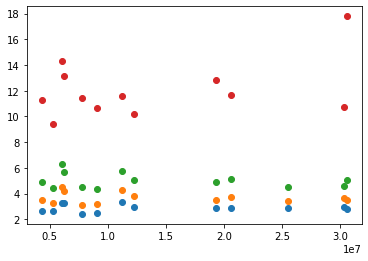

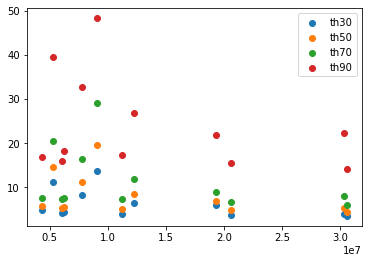

In [10]:
import matplotlib.pyplot as plt

eval_df = eval_dfs[0]

plt.scatter(eval_df.parameters[4:], eval_df.th30[4:], label='th30_32')
plt.scatter(eval_df.parameters[4:], eval_df.th50[4:], label='th30_32')
plt.scatter(eval_df.parameters[4:], eval_df.th70[4:], label='th30_32')
plt.scatter(eval_df.parameters[5:], eval_df.th90[5:], label='th90')
plt.show()


eval_df = eval_dfs[1]
plt.scatter(eval_df.parameters[5:], eval_df.th30[5:], label='th30')
plt.scatter(eval_df.parameters[5:], eval_df.th50[5:], label='th50')
plt.scatter(eval_df.parameters[5:], eval_df.th70[5:], label='th70')
plt.scatter(eval_df.parameters[5:], eval_df.th90[5:], label='th90')
plt.legend()
plt.show()

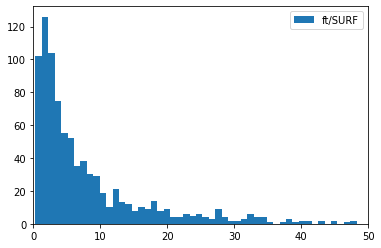

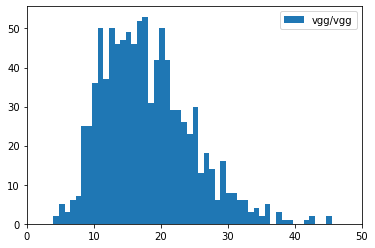

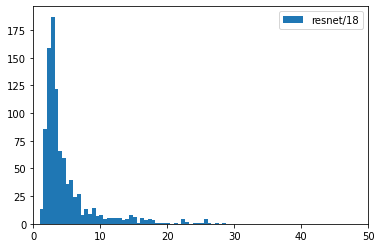

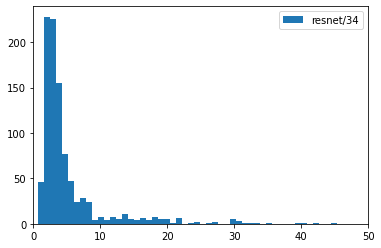

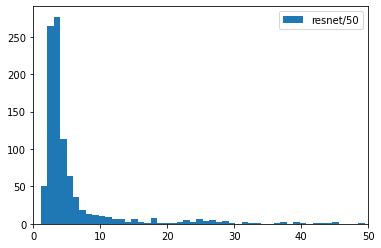

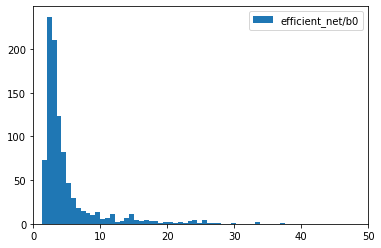

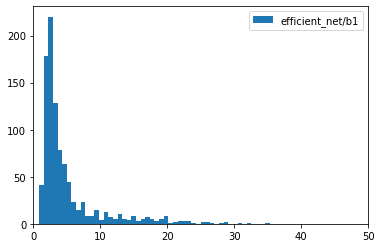

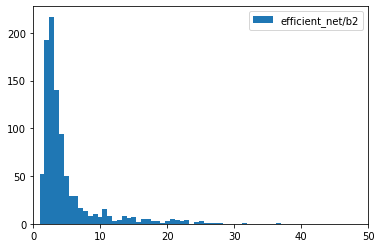

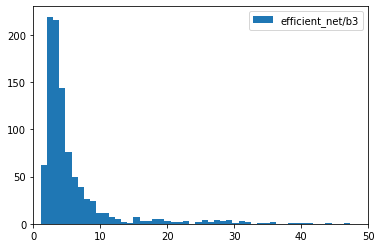

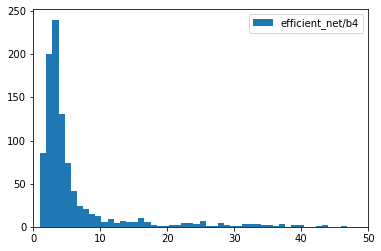

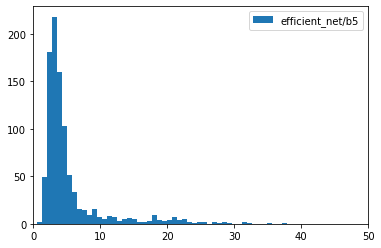

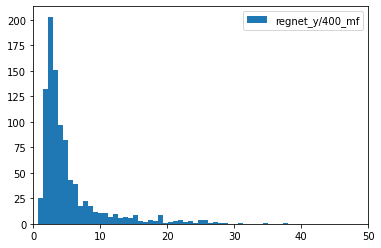

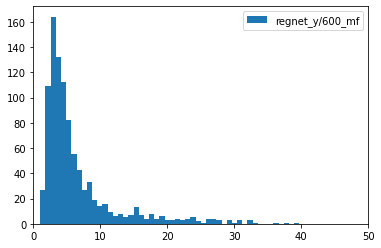

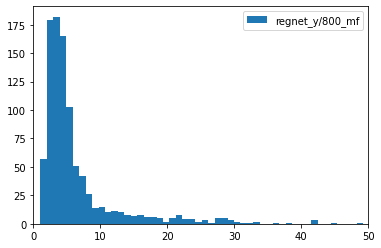

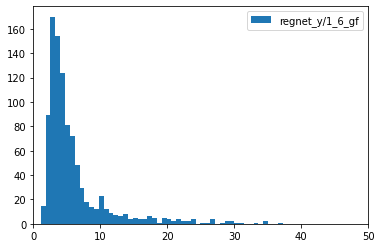

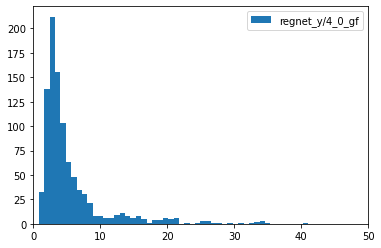

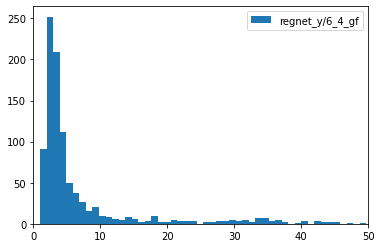

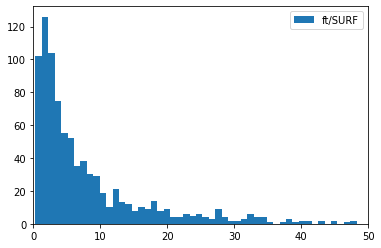

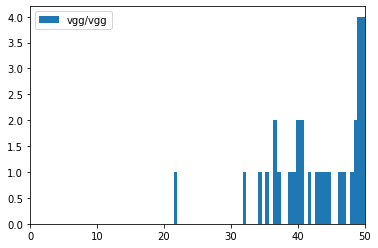

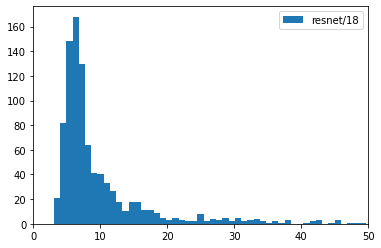

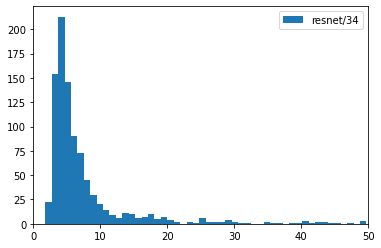

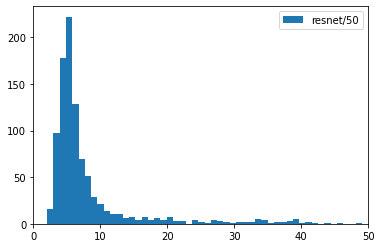

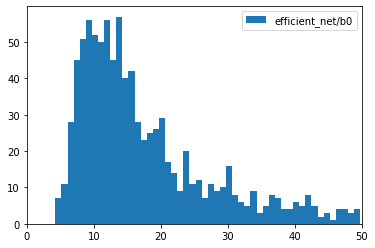

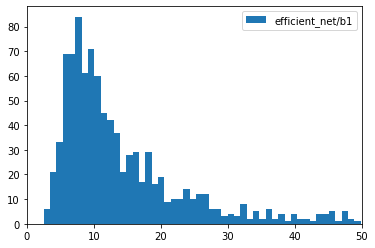

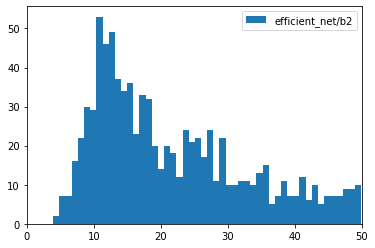

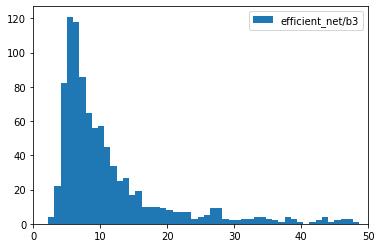

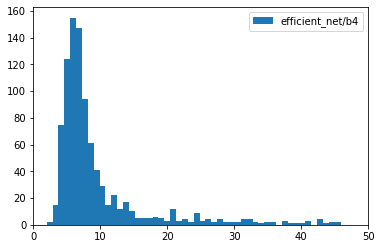

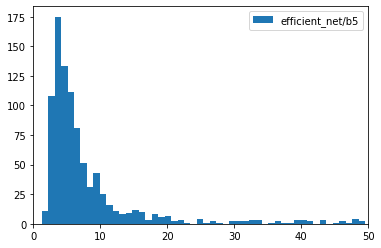

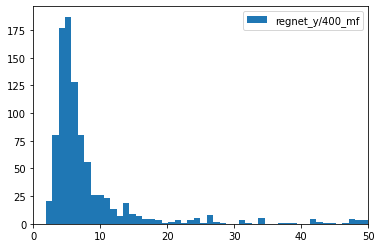

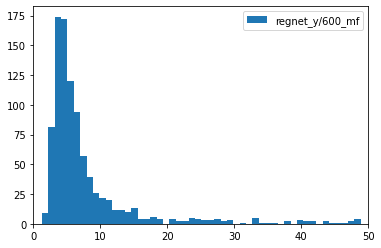

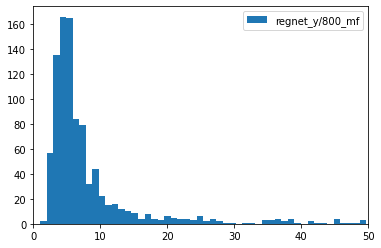

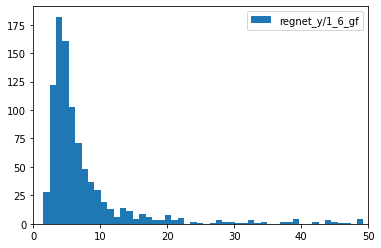

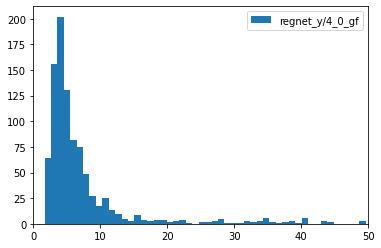

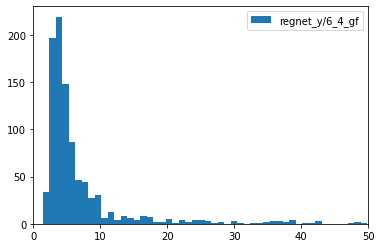

In [8]:
for rho in rhos:

    eval_df = pd.DataFrame(columns=['parameters', 'th30', 'th50', 'th70', 'th90'])

    for fd in fds:
        data_path = 'fw_bw_consistency/rho_{}/{}_duv.pkl'.format(rho, fd)
        duv_df = pd.read_pickle(data_path)

        duv_df['duv_mpd'] = duv_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

        lim = 50
        duv_mpd = duv_df['duv_mpd'][duv_df['duv_mpd'] < lim]

        plt.hist(duv_mpd, bins=lim, label=fd)
        plt.xlim([0, 50])
        plt.legend()
        plt.show()
        